In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt 
import nc_time_axis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
import statsmodels.api as sm

### Open Precipitation Data and Plot Components (Globally, Tropics, Mid-Latitude, High Latitudes)

I am going to start by looking at the trend in precipitation. The Adler et al (2017) paper shows that there is an increase in precipitation regionally. It is more pronounced in the tropics with weaker signals in the higher latitudes. There is also a region in the swath at 60˚N (particularly over Asia) where there is a general increase. So first the time series from start_date to end_date will be broken into its components (seasonality, trend, remainder) for the entire globe averaged, tropic, mid-latitudes, and high latidues for the Northern Hempisphere to visually assess the trend in precpitation. Seasonality cannot be present in the Man-Kendall Trend test so this should be apparent with the components. 

In [2]:
# Open precpitation file in xarray
precip_dat = xr.open_dataset("/home/bdavis39/Courses/CLIM690/precip.mon.total.1x1.v2020.nc", use_cftime=True, decode_times=True)

In [3]:
# Display original data
precip_dat

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1548)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 1891-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/download_gate....
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2020 1.0x1.0 Monthly ...
    history:          Created 07/2021  based on V2020 data obtained via ftp
    References:       https://www.psl.noaa.gov/data/gridded/data.gpcc.html

Need to find period of dataset for use in decomposition of components. The statsmodel autocorrelation library is used for 5 years of the precip. data

In [4]:
# Take first years to autocorrelate and find period
per_pdat = precip_dat.sel(time=slice('1980-01-01','1985-12-01'))
per_pdat_glob = per_pdat.mean(dim='lat').mean(dim='lon')

In [5]:
# Calculate autocorrelation of function 
acorr = sm.tsa.acf(np.array(per_pdat_glob.precip[:]), nlags = len(per_pdat.precip)-1)

In [6]:
acorr

array([ 1.00000000e+00,  6.39500490e-01,  1.86390123e-01, -2.30120703e-01,
       -4.04880709e-01, -3.74471174e-01, -3.57980822e-01, -3.22729475e-01,
       -3.18807995e-01, -1.88990262e-01,  1.25917530e-01,  4.74067852e-01,
        7.44323281e-01,  5.04484875e-01,  1.55486830e-01, -2.08983524e-01,
       -3.60509387e-01, -3.38368683e-01, -3.27223318e-01, -2.87073682e-01,
       -2.77465046e-01, -1.44981699e-01,  1.14261897e-01,  3.78021950e-01,
        5.88138603e-01,  3.83288311e-01,  1.13252807e-01, -1.54609078e-01,
       -2.56249370e-01, -2.44638516e-01, -2.58251367e-01, -2.37916778e-01,
       -2.20083951e-01, -1.02527663e-01,  9.90141907e-02,  3.21769480e-01,
        4.65179909e-01,  2.92696763e-01,  7.04799083e-02, -1.34807114e-01,
       -2.01334426e-01, -1.51018367e-01, -1.45114006e-01, -1.43808770e-01,
       -1.46819567e-01, -7.96179462e-02,  6.13196802e-02,  2.19618614e-01,
        3.16059031e-01,  2.22686117e-01,  5.85729504e-02, -9.32921592e-02,
       -1.42840317e-01, -

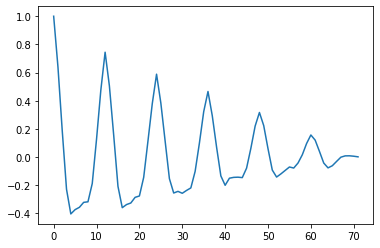

In [7]:
# Plot autocorrelation function
plt.plot(acorr)

Peaks occur at around repeated intervals of 12 in this case so 12 will be used as the period for the decomposition

Next I will take the full dataset for the period of interest and determine if there is an additive or multiplicative model for decomposition

In [8]:
# save xarray dataset with time slice from 1980 to 2019
pdat = precip_dat.sel(time=slice('1980-01-01','2019-12-01'))

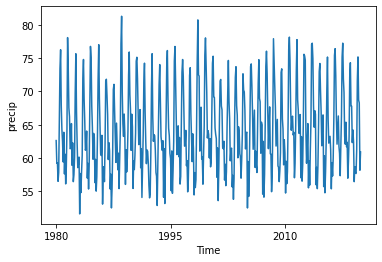

In [9]:
# Take average of data over all lats and lons (Global)
glob_p = pdat.precip.mean(dim='lat').mean(dim='lon')
glob_p.plot()

Results look similar for trend decomposition using seasonal_decompose and Season-Trend decomposition (STL) use LOESS. The latter was a bit smoother but in general when season_decompose is set to the additive model and the period is 12, each look similar. 

In [10]:
# Take a look at global trend decomposition
result_glob_add = seasonal_decompose(glob_p, model='additive', period=12) # additive
result_glob_mult = seasonal_decompose(glob_p, model='multiplicative', period=12) # multiplicative
result_glob_STL = STL(glob_p, period=12).fit() # stl
result_glob_STL_rob = STL(glob_p, period=12, robust=True).fit() # stl robust

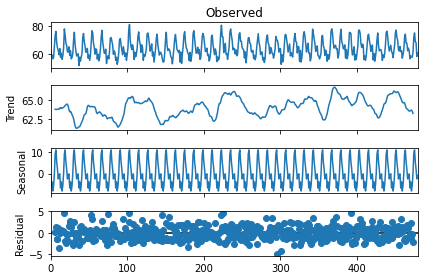

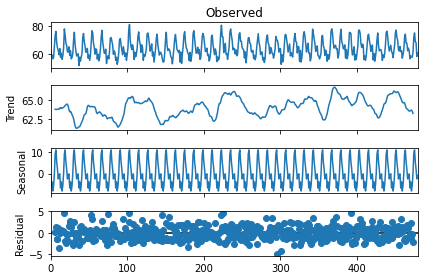

In [11]:
# plot trend decompositon using the additive model
result_glob_add.plot()

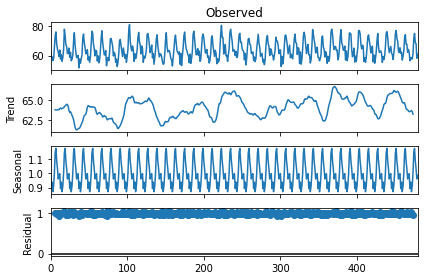

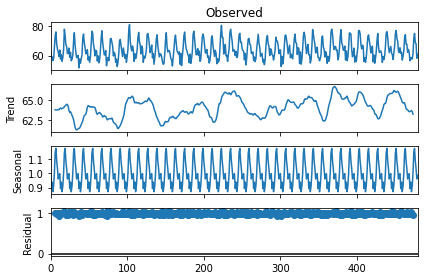

In [12]:
# plot trend decompositon using the multiplicative model
result_glob_mult.plot()

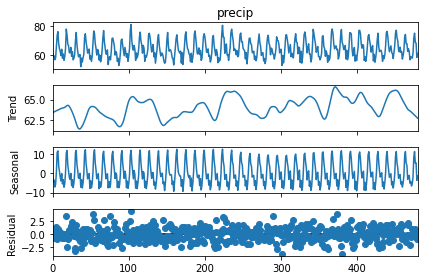

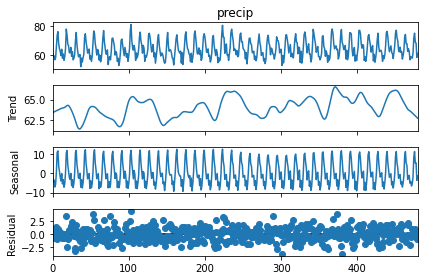

In [13]:
# plot trend decompositon using the stl model
result_glob_STL.plot()

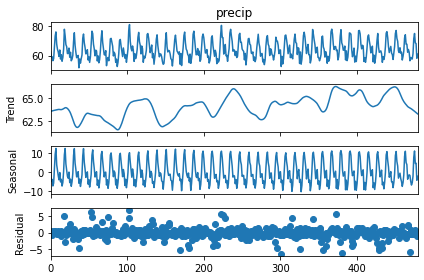

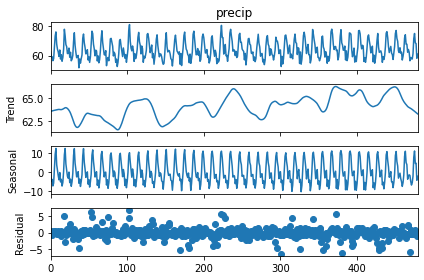

In [14]:
# plot trend decompositon using the stl robust model
result_glob_STL_rob.plot()

Both seasonal trends look fairly constant however the residual plots are only constant for the multiplicative model but all values are equal to 1. The STL has variance in the seasonal plot but the residuals for the robust method has less variance. The STL seems more robust so I will use that on going forward.

#### Kendall Seasonality Test (for Trends)

I now going to apply the Seasonal Kendell Test to the global model to see if there is a trend globally.

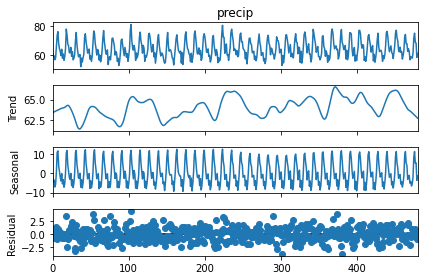

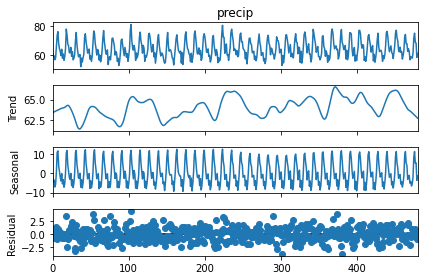

In [15]:
# Going forward the stl model will be used.
result_glob = STL(glob_p, period=12, robust=False).fit()
result_glob.plot()

In [16]:
# perform a smk on the global precip. data
print(mk.seasonal_test(glob_p,period=12))

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=1.1327680105033266e-07, z=5.304024980660923, Tau=0.1685897435897436, s=1578.0, var_s=88400.00000000001, slope=0.04459961722878849, intercept=62.29179651480095)


In [17]:
# find propotion of variance explained by trend (if negative set value to 0)
Ft_glob = max(0,(1-(np.nanvar(result_glob.resid)/np.nanvar(result_glob.resid+result_glob.trend))))
Ft_glob

0.5302460630830388

The Mann_Kendall Test indicates there is an increasing trend, as the h value is true, p is less than 0.05, and the score is positive. Additionally, the trend strength is greater than .50 indicating a moderately strong trend upwards. Next I will assess the strength of the trend for comparison with the latitudinal regions.

In [18]:
# Take swaths of latitudes in northern hemisphere then average across lats and lons
trop_p = pdat.precip.sel(lat=slice(30,0)).mean(dim='lat').mean(dim='lon')
midlat_p = pdat.precip.sel(lat=slice(60,30)).mean(dim='lat').mean(dim='lon')
hghlat_p = pdat.precip.sel(lat=slice(90,60)).mean(dim='lat').mean(dim='lon')

In [19]:
# Decompose each latitudinal region
result_trop = STL(trop_p, period=12).fit()
result_midlat = STL(midlat_p, period=12).fit()
result_hghlat = STL(hghlat_p, period=12).fit()

Seasonal_Mann_Kendall_Test(trend='no trend', h=False, p=0.8427020178344877, z=0.19843847422891214, Tau=0.00641025641025641, s=60.0, var_s=88400.00000000001, slope=0.006393565137688043, intercept=106.77224021908467)
Trend Strength: 0.4829310497291839


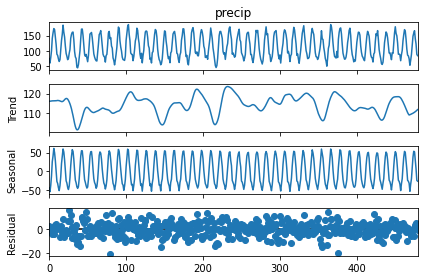

In [20]:
# Plot the decomposition, conduct Seasonal Kendall Test, calculate trend strength
result_trop.plot()
print(mk.seasonal_test(trop_p,period=12))
Ft_trop = max(0,(1-(np.nanvar(result_trop.resid)/np.nanvar(result_trop.resid+result_trop.trend))))
print(f'Trend Strength: {Ft_trop}')

Seasonal_Mann_Kendall_Test(trend='no trend', h=False, p=0.380031641396227, z=0.8778379961651877, Tau=0.027991452991452993, s=262.0, var_s=88400.00000000001, slope=0.01640683128720238, intercept=69.44409240238251)
Trend Strength: 0.20042594481523068


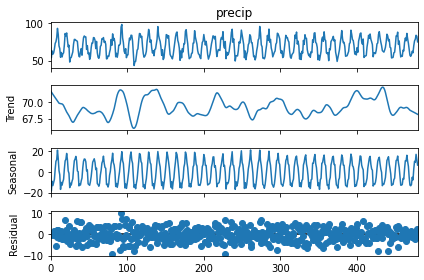

In [21]:
result_midlat.plot()
print(mk.seasonal_test(midlat_p,period=12))
Ft_midlat = max(0,(1-(np.nanvar(result_midlat.resid)/np.nanvar(result_midlat.resid+result_midlat.trend))))
print(f'Trend Strength: {Ft_midlat}')

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=7.530987566894964e-08, z=5.378018988000517, Tau=0.17094017094017094, s=1600.0, var_s=88400.00000000001, slope=0.06462919642353615, intercept=29.394415099427945)
Trend Strength: 0.3066287749820542


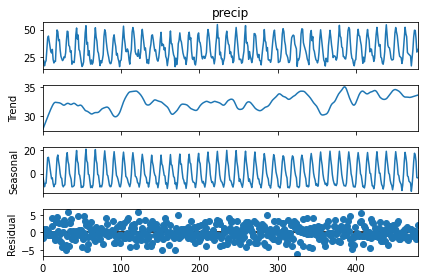

In [22]:
result_hghlat.plot()
print(mk.seasonal_test(hghlat_p,period=12))
Ft_hghlat = max(0,(1-(np.nanvar(result_hghlat.resid)/np.nanvar(result_hghlat.resid+result_hghlat.trend))))
print(f'Trend Strength: {Ft_hghlat}')

Oddly enough, trends are only seen in high latitudes. My assumnption may be that changes in precipitation vary in different directions at the lower latitudes so there may be a balance that is altering the overall trend. However in the higher latitudes, there is primarily an increase which is why that signal may be very large.